Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]/tmp/ipykernel_343394/2177070472.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred, label = torch.nn.functional.softmax(out).max(1)
100it [00:08, 11.55it/s]


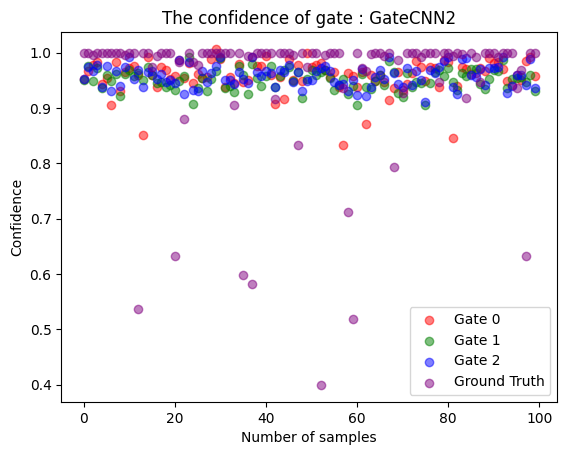

In [4]:
import torch
from tqdm import tqdm
# check the distribution of the gate outputs
# load the dataset
from Dataloaders.dataloader_cifar10 import Dataloader_cifar10
_, test, classes = Dataloader_cifar10(train_batch=128, test_batch=100, seed=2024)
# load the model
from Models import mobilenetv2
client, server = mobilenetv2.stupid_model_splitter(weight_path='./Weights/cifar-10/model/MobileNetV2.pth')
# load the gate
from Models import gatedmodel
gateds = []
gated_rates = [0.25, 0.5, 0.75]
input_size = [8, 16, 24, 32]
for i in range(3):
    gateds.append(gatedmodel.model_list['GateCNN2'](
        input_size=input_size[i],
        width=32,
        height=32,
        output_size=1)) #  input_size, weight, height, output_size=10
    s_time = '2024_06_14_17_46_36'
    gateds[i].load_state_dict(torch.load('./Weights/cifar-10/gate/'+s_time+'/GateCNN2_'+str(i)+'_'+s_time+'.pth'))

# load the ranker
from Utils import utils

ranker = utils.ranker_entropy

# load the generator
from Models import generator
generators = []
for i in range(3):
    generators.append(generator.Generator(
        inputsize=input_size[i], 
        hiddensize=32, 
        outputsize=32)) # inputsize, hiddensize, outputsize
    
# set them to eval
client.eval()
server.eval()
for i in range(3):
    gateds[i].eval()
    generators[i].eval()
client = client.cuda()
server = server.cuda()
for i in range(3):
    gateds[i] = gateds[i].cuda()
    generators[i] = generators[i].cuda()

# plot the confidence of distribution of the gate
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    conf = [[], [], []]
    gt_conf = []
    for i, data in tqdm(enumerate(test)):
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        out = client(images)
        for j in range(3):
            s_emb, s_ind = ranker(out.cpu(), gated_rates[j])
            s_emb = s_emb.cuda() #b,e',h,w
            cur_gated = gateds[j].cuda() 
            l_conf = cur_gated(s_emb) # b, n
            conf[j] = conf[j] + l_conf.detach().cpu().tolist()
        # get the confidence on the server
        out = server(out)
        pred, label = torch.nn.functional.softmax(out).max(1)
        gt_conf = gt_conf + pred.tolist()


# plot
plt.figure()
# plot scatter, x is the number of sample
colors = ['r', 'g', 'blue']
for i in range(3):
    plt.scatter(range(len(conf[i][:100])), conf[i][:100], label='Gate '+str(i), c=colors[i], alpha=0.5)
plt.scatter(range(len(gt_conf[:100])), gt_conf[:100], label='Ground Truth', c='purple', alpha=0.5)

plt.title('The confidence of gate : GateCNN2')
plt.legend(loc='best')
plt.xlabel('Number of samples')
plt.ylabel('Confidence')
plt.show()


Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]/tmp/ipykernel_343394/3522529583.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred, label = torch.nn.functional.softmax(out).max(1)
100it [00:08, 11.67it/s]


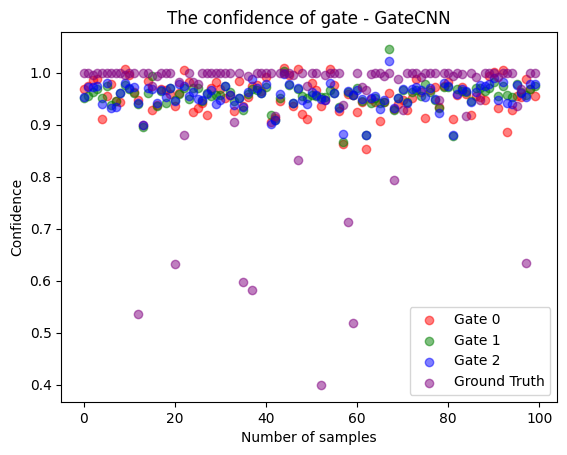

In [5]:
# check the distribution of the gate outputs
# load the dataset
from Dataloaders.dataloader_cifar10 import Dataloader_cifar10
_, test, classes = Dataloader_cifar10(train_batch=128, test_batch=100, seed=2024)
# load the model
from Models import mobilenetv2
client, server = mobilenetv2.stupid_model_splitter(weight_path='./Weights/cifar-10/model/MobileNetV2.pth')
# load the gate
from Models import gatedmodel
gateds = []
gated_rates = [0.25, 0.5, 0.75]
input_size = [8, 16, 24, 32]
for i in range(3):
    gateds.append(gatedmodel.model_list['GateCNN'](
        input_size=input_size[i],
        width=32,
        height=32,
        output_size=1)) #  input_size, weight, height, output_size=10
    s_time = '2024_06_14_17_46_36'
    gateds[i].load_state_dict(torch.load('./Weights/cifar-10/gate/'+s_time+'/GateCNN_'+str(i)+'_'+s_time+'.pth'))

# load the ranker
from Utils import utils

ranker = utils.ranker_entropy

# load the generator
from Models import generator
generators = []
for i in range(3):
    generators.append(generator.Generator(
        inputsize=input_size[i], 
        hiddensize=32, 
        outputsize=32)) # inputsize, hiddensize, outputsize
    
# set them to eval
client.eval()
server.eval()
for i in range(3):
    gateds[i].eval()
    generators[i].eval()
client = client.cuda()
server = server.cuda()
for i in range(3):
    gateds[i] = gateds[i].cuda()
    generators[i] = generators[i].cuda()

# plot the confidence of distribution of the gate
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    conf = [[], [], []]
    gt_conf = []
    for i, data in tqdm(enumerate(test)):
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        out = client(images)
        for j in range(3):
            s_emb, s_ind = ranker(out.cpu(), gated_rates[j])
            s_emb = s_emb.cuda() #b,e',h,w
            cur_gated = gateds[j].cuda() 
            l_conf = cur_gated(s_emb) # b, n
            conf[j] = conf[j] + l_conf.detach().cpu().tolist()
        # get the confidence on the server
        out = server(out)
        pred, label = torch.nn.functional.softmax(out).max(1)
        gt_conf = gt_conf + pred.tolist()


# plot
plt.figure()
# plot scatter, x is the number of sample
colors = ['r', 'g', 'blue']
for i in range(3):
    plt.scatter(range(len(conf[i][:100])), conf[i][:100], label='Gate '+str(i), c=colors[i], alpha=0.5)
plt.scatter(range(len(gt_conf[:100])), gt_conf[:100], label='Ground Truth', c='purple', alpha=0.5)

plt.title('The confidence of gate - GateCNN')
plt.legend(loc='best')
plt.xlabel('Number of samples')
plt.ylabel('Confidence')
plt.show()


Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]/tmp/ipykernel_343394/3042255226.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred, label = torch.nn.functional.softmax(out).max(1)
100it [00:08, 11.89it/s]


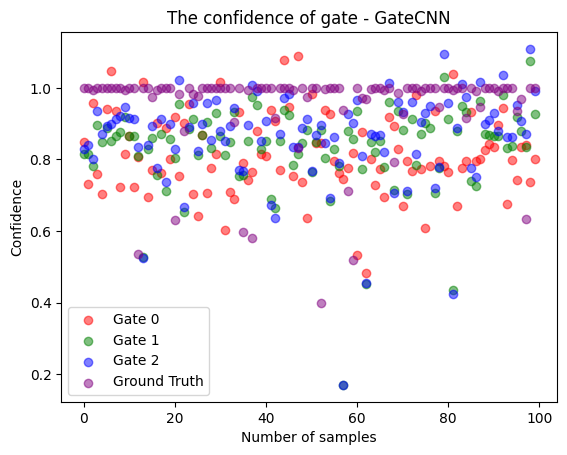

In [6]:
# check the distribution of the gate outputs
# load the dataset
from Dataloaders.dataloader_cifar10 import Dataloader_cifar10
_, test, classes = Dataloader_cifar10(train_batch=128, test_batch=100, seed=2024)
# load the model
from Models import mobilenetv2
client, server = mobilenetv2.stupid_model_splitter(weight_path='./Weights/cifar-10/model/MobileNetV2.pth')
# load the gate
from Models import gatedmodel
gateds = []
gated_rates = [0.25, 0.5, 0.75]
input_size = [8, 16, 24, 32]
for i in range(3):
    gateds.append(gatedmodel.model_list['GateMLP'](
        input_size=input_size[i],
        width=32,
        height=32,
        output_size=1)) #  input_size, weight, height, output_size=10
    s_time = '2024_06_14_17_46_36'
    gateds[i].load_state_dict(torch.load('./Weights/cifar-10/gate/'+s_time+'/GateMLP_'+str(i)+'_'+s_time+'.pth'))

# load the ranker
from Utils import utils

ranker = utils.ranker_entropy

# load the generator
from Models import generator
generators = []
for i in range(3):
    generators.append(generator.Generator(
        inputsize=input_size[i], 
        hiddensize=32, 
        outputsize=32)) # inputsize, hiddensize, outputsize
    
# set them to eval
client.eval()
server.eval()
for i in range(3):
    gateds[i].eval()
    generators[i].eval()
client = client.cuda()
server = server.cuda()
for i in range(3):
    gateds[i] = gateds[i].cuda()
    generators[i] = generators[i].cuda()

# plot the confidence of distribution of the gate
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    conf = [[], [], []]
    gt_conf = []
    for i, data in tqdm(enumerate(test)):
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        out = client(images)
        for j in range(3):
            s_emb, s_ind = ranker(out.cpu(), gated_rates[j])
            s_emb = s_emb.cuda() #b,e',h,w
            cur_gated = gateds[j].cuda() 
            l_conf = cur_gated(s_emb) # b, n
            conf[j] = conf[j] + l_conf.detach().cpu().tolist()
        # get the confidence on the server
        out = server(out)
        pred, label = torch.nn.functional.softmax(out).max(1)
        gt_conf = gt_conf + pred.tolist()


# plot
plt.figure()
# plot scatter, x is the number of sample
# random select 1% of the samples
colors = ['r', 'g', 'blue']
for i in range(3):
    plt.scatter(range(len(conf[i][:100])), conf[i][:100], label='Gate '+str(i), c=colors[i], alpha=0.5)
plt.scatter(range(len(gt_conf[:100])), gt_conf[:100], label='Ground Truth', c='purple', alpha=0.5)

plt.title('The confidence of gate - GateCNN')
plt.legend(loc='best')
plt.xlabel('Number of samples')
plt.ylabel('Confidence')
plt.show()
